In [1]:
#https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis
#1.6 million tweets
#Dataframe
import pandas as pd

#Matplot
import matplotlib.pyplot as plt
%matplotlib inline

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#Word2vec
import gensim

#Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2022-12-02 00:45:38.677027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nfanlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

#TEXT CLEARING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

#WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

#KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

#SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

#EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
#Dataset details
#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
#ids: The id of the tweet ( 2087)
#date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
#flag: The query (lyx). If there is no query, then this value is NO_QUERY.
#user: the user that tweeted (robotickilldozr)
#text: the text of the tweet (Lyx is cool)

#Open dataset
#import os
#dataset_filename = os.listdir("/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/Kaggle_Twitter sentiment Analysis (NLTK) /training.1600000.processed.noemoticon.csv")[0]
#dataset_path = os.path.join("/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/Kaggle_Twitter sentiment Analysis (NLTK) /training.1600000.processed.noemoticon.csv",dataset_filename)
#print("Open file:", dataset_path)
df = pd.read_csv("/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/Kaggle_Twitter sentiment Analysis (NLTK) /training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING, names=DATASET_COLUMNS)


In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.tail()

,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [7]:
#Map target label to String
#0 -> NEGATIVE
#2 -> NEUTRAL
#4 -> POSITIVE

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 374 ms, sys: 6.16 ms, total: 380 ms
Wall time: 393 ms


In [9]:
df.tail()

,target,ids,date,flag,user,text
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,POSITIVE,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


Text(0.5, 1.0, 'dataset labels distribuition')

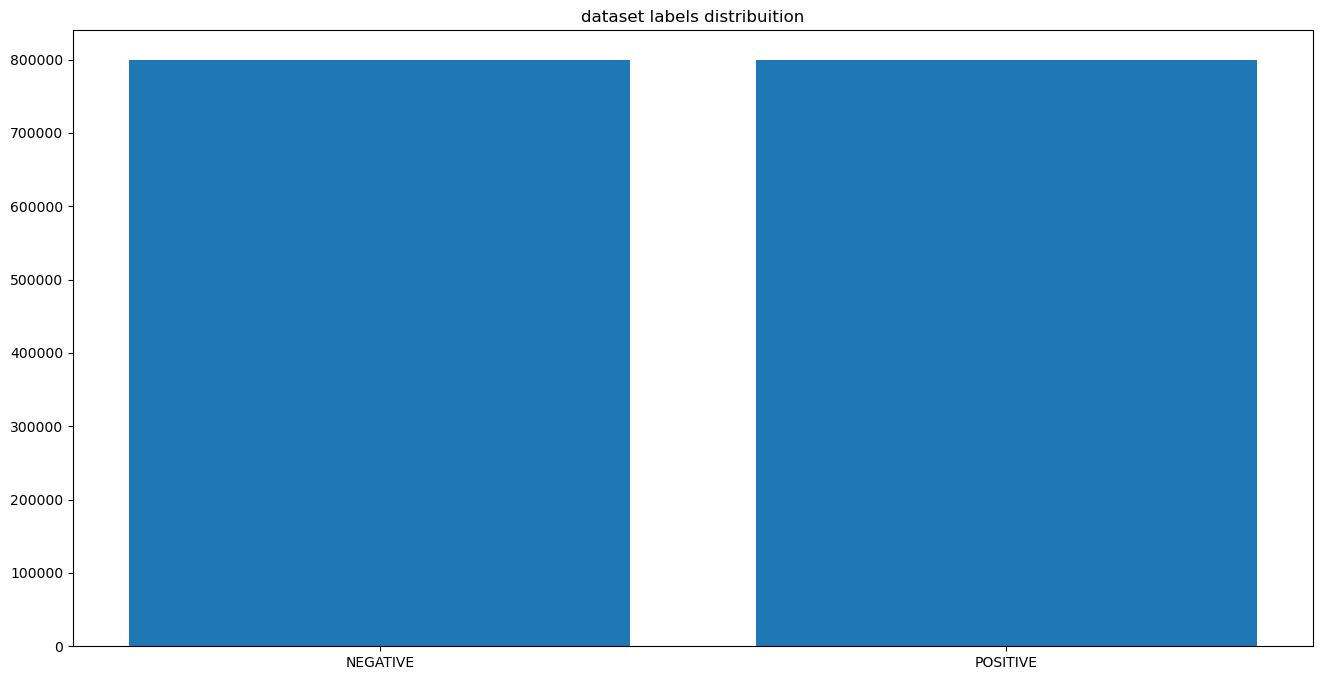

In [10]:
target_cnt = Counter(df.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("dataset labels distribuition")

In [11]:
#Pre-Process dataset
stop_words= stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    #Remove link, usera and special characters
    text = re.sub(TEXT_CLEANING_RE, '', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return "".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 12.2 s, sys: 131 ms, total: 12.3 s
Wall time: 12.4 s


In [20]:
print(df.tail())

           target         ids                          date      flag  \
1599995  POSITIVE  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996  POSITIVE  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997  POSITIVE  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998  POSITIVE  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999  POSITIVE  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
1599995  AmandaMarie1028       justwokeuphavingnoschoolisthebestfeelingever  
1599996      TheWDBoards           thewdbcomverycooltohearoldwaltinterviews  
1599997           bpbabe      areyoureadyforyourmojomakeoveraskmefordetails  
1599998     tinydiamondz  happy38thbirthdaytomybooofallltimetupacamarush...  
1599999   RyanTrevMorris  happycharitytuesdaythenspccsparkscharityspeaki...  


In [21]:
#Split train and test
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.82 s, sys: 85.3 ms, total: 1.9 s
Wall time: 1.91 s


In [26]:
print(documents[:10])

[['withyaquotidlikeapalmpretouchstonechargerreadynowyesthatsoundsgoodbutismybeerreadynowprelaunch'], ['felttheearthquakethisafternoonitseemstobeabutattheepicenter'], ['rufflesonshirtsarelikesoinmelikey'], ['prettybadnightintoacrappymorningfmlifonlybuttfacedidntsayhecouldgointoworktoday'], ['yeahwhataclearview'], ['onemoretimefollowmyfamffgeorgeann13nakithebeatmanflimackgodchaz81djtellejaejaedynomitewelcometofridayfollowme2'], ['urockthankswillbeaddedtonextrobcrotchtmvideo'], ['yespleasemetyourfianceeatianspartytheotherdaybtwshesverysweetcongratstoyouguys'], ['mygawdtheyvefinishedthewholebowlbeforeievenpostedmyprevioustweetmaking2ndbowl'], ['awesomegamebutveryshortyoullfinishitandbecravingformoregodofwaraction']]


In [27]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-12-02 00:51:49,096 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-12-02T00:51:49.096618', 'gensim': '4.2.0', 'python': '3.7.15 (default, Nov 10 2022, 12:46:26) \n[Clang 14.0.6 ]', 'platform': 'Darwin-21.3.0-x86_64-i386-64bit', 'event': 'created'}


In [28]:
w2v_model.build_vocab(documents)

2022-12-02 00:51:51,770 : INFO : collecting all words and their counts
2022-12-02 00:51:51,771 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-12-02 00:51:51,780 : INFO : PROGRESS: at sentence #10000, processed 9970 words, keeping 9877 word types
2022-12-02 00:51:51,789 : INFO : PROGRESS: at sentence #20000, processed 19941 words, keeping 19709 word types
2022-12-02 00:51:51,799 : INFO : PROGRESS: at sentence #30000, processed 29915 words, keeping 29503 word types
2022-12-02 00:51:51,810 : INFO : PROGRESS: at sentence #40000, processed 39892 words, keeping 39280 word types
2022-12-02 00:51:51,824 : INFO : PROGRESS: at sentence #50000, processed 49870 words, keeping 49041 word types
2022-12-02 00:51:51,833 : INFO : PROGRESS: at sentence #60000, processed 59841 words, keeping 58775 word types
2022-12-02 00:51:51,844 : INFO : PROGRESS: at sentence #70000, processed 69816 words, keeping 68512 word types
2022-12-02 00:51:51,853 : INFO : PROGRESS: at sentence 

2022-12-02 00:51:52,636 : INFO : PROGRESS: at sentence #720000, processed 718221 words, keeping 691361 word types
2022-12-02 00:51:52,676 : INFO : PROGRESS: at sentence #730000, processed 728198 words, keeping 700843 word types
2022-12-02 00:51:52,687 : INFO : PROGRESS: at sentence #740000, processed 738171 words, keeping 710289 word types
2022-12-02 00:51:52,697 : INFO : PROGRESS: at sentence #750000, processed 748147 words, keeping 719764 word types
2022-12-02 00:51:52,710 : INFO : PROGRESS: at sentence #760000, processed 758118 words, keeping 729287 word types
2022-12-02 00:51:52,720 : INFO : PROGRESS: at sentence #770000, processed 768086 words, keeping 738767 word types
2022-12-02 00:51:52,731 : INFO : PROGRESS: at sentence #780000, processed 778060 words, keeping 748228 word types
2022-12-02 00:51:52,742 : INFO : PROGRESS: at sentence #790000, processed 788031 words, keeping 757706 word types
2022-12-02 00:51:52,753 : INFO : PROGRESS: at sentence #800000, processed 798002 words, 

In [29]:
print(w2v_model)

Word2Vec<vocab=951, vector_size=300, alpha=0.025>


In [30]:
#guarda en words las keys del indice
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 951


In [31]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-12-02 00:52:02,477 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 951 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-12-02T00:52:02.477831', 'gensim': '4.2.0', 'python': '3.7.15 (default, Nov 10 2022, 12:46:26) \n[Clang 14.0.6 ]', 'platform': 'Darwin-21.3.0-x86_64-i386-64bit', 'event': 'train'}
2022-12-02 00:52:03,489 : INFO : EPOCH 0 - PROGRESS: at 77.54% examples, 19072 words/s, in_qsize 0, out_qsize 1
2022-12-02 00:52:03,760 : INFO : EPOCH 0: training on 1276830 raw words (24775 effective words) took 1.3s, 19453 effective words/s
2022-12-02 00:52:04,774 : INFO : EPOCH 1 - PROGRESS: at 73.62% examples, 18072 words/s, in_qsize 0, out_qsize 1
2022-12-02 00:52:05,094 : INFO : EPOCH 1: training on 1276830 raw words (24895 effective words) took 1.3s, 18777 effective words/s
2022-12-02 00:52:06,103 : INFO : EPOCH 2 - PROGRESS: at 85.37% examples, 21031 words/s, in_qsize 0, out_qsize 0
2

2022-12-02 00:52:41,418 : INFO : Word2Vec lifecycle event {'msg': 'training on 40858560 raw words (794091 effective words) took 38.9s, 20393 effective words/s', 'datetime': '2022-12-02T00:52:41.418571', 'gensim': '4.2.0', 'python': '3.7.15 (default, Nov 10 2022, 12:46:26) \n[Clang 14.0.6 ]', 'platform': 'Darwin-21.3.0-x86_64-i386-64bit', 'event': 'train'}


CPU times: user 39.1 s, sys: 852 ms, total: 40 s
Wall time: 38.9 s


(794091, 40858560)

In [32]:
#Tokenizer text (separar la frase en palabras)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 1220697


In [33]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [34]:
#Label encoder
#Juntamos toda la lista en labels y la convertimos a lista
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [35]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [36]:
#Miramos las dimensiones de las matrices
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [37]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [38]:
#Embedding layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(1220697, 300)


In [39]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [40]:
#Build a sequential model with keras
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-12-02 00:57:38.758834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          366209100 
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 366,369,601
Trainable params: 160,501
Non-trainable params: 366,209,100
_________________________________________________________________


In [34]:
#Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
#Callbacks
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [38]:
#Train model
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

1125/1125 [==============================] - 4606s 4s/step - loss: 0.6924 - accuracy: 0.5039 - val_loss: 0.6913 - val_accuracy: 0.5083 - lr: 0.0010


In [39]:
#Evaluate model
score = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 248s 789ms/step - loss: 0.6912 - accuracy: 0.5063

ACCURACY: 0.5063187479972839
LOSS: 0.6912016868591309


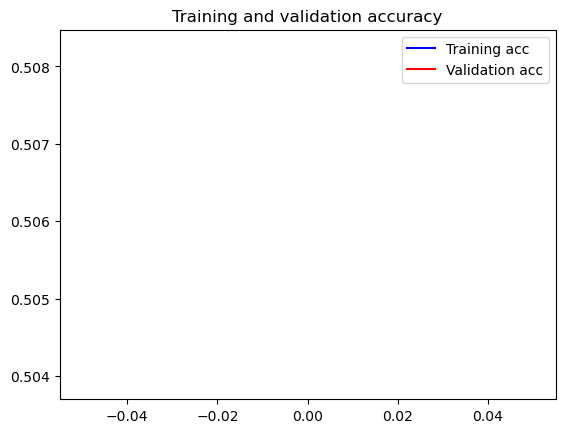

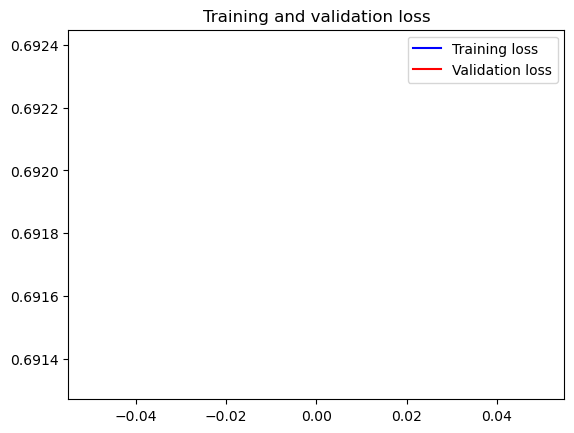

In [47]:
#Graficamos evaluate model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [48]:
#Predicción
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [49]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [51]:
predict("I hate the rain a lot")

1/1 [==============================] - 0s 39ms/step


{'label': 'NEUTRAL',
 'score': 0.49661582708358765,
 'elapsed_time': 0.08388471603393555}

In [67]:
#Confussion matrix

y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


40/40 [==============================] - 264s 7s/step


In [64]:
#Graficamos confussion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


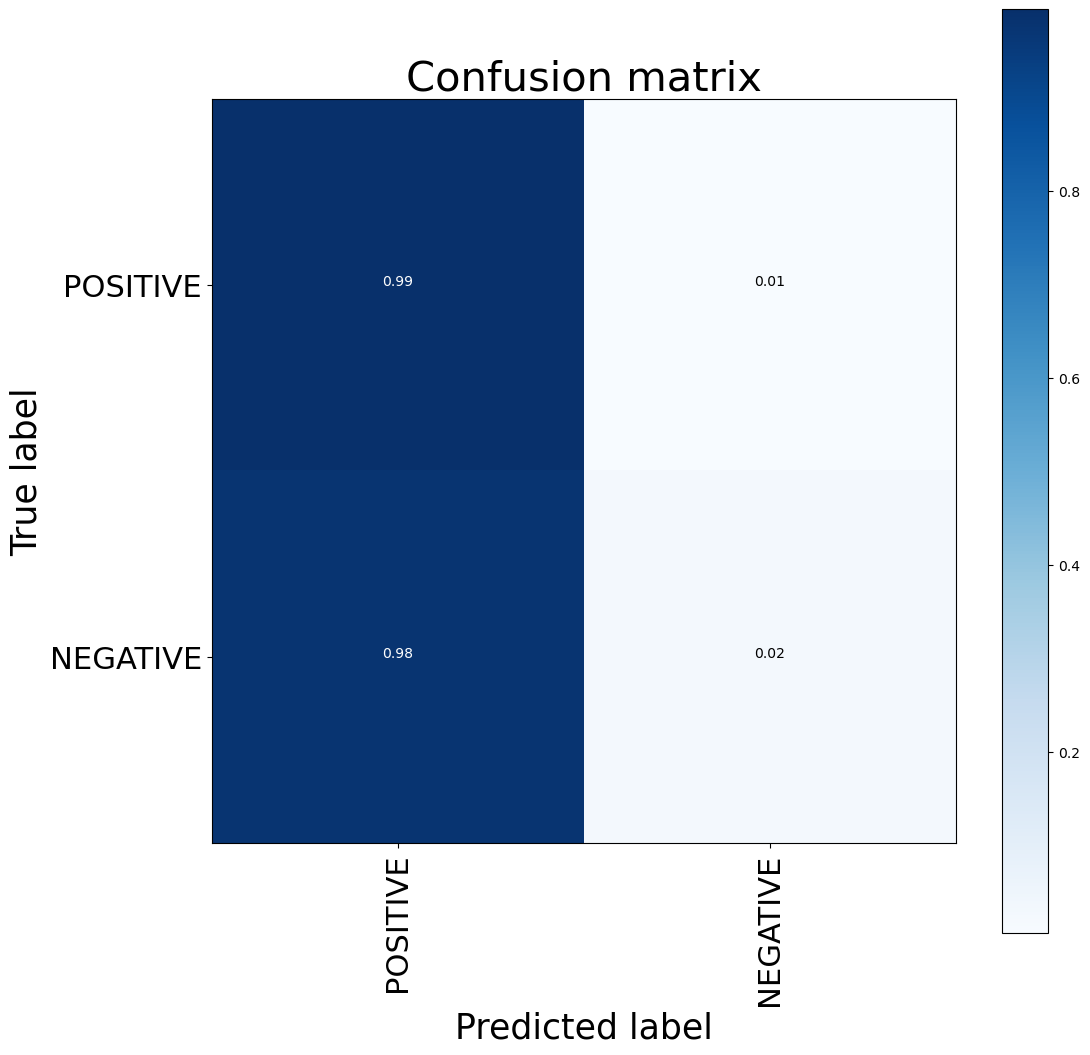

In [68]:


cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [69]:
#Classification report
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.50      0.99      0.67    159494
    POSITIVE       0.79      0.02      0.04    160506

    accuracy                           0.51    320000
   macro avg       0.65      0.51      0.35    320000
weighted avg       0.65      0.51      0.35    320000



In [70]:
#Accuracy score
accuracy_score(y_test_1d, y_pred_1d)

0.50631875